# POSGGym-agents policy analysis

This script can be used for visualizing the pairwise performance of implemented policies.

The actual results files are stored in the `posggym-agents/analysis/results` directory.


## Notation

- **Same-play** refers to pairings of policies that are trained together or at least trained as part of the same population
- **Cross-play** refers to pairings of policies that were not trained together

In [1]:
import os
import os.path as osp
import sys 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import posggym

from posggym_agents.agents.registration import parse_policy_id
from posggym_agents.config import BASE_DIR, BASE_REPO_DIR

sys.path.append(osp.join(BASE_REPO_DIR, "analysis"))
import plot_utils

agent_dir = osp.join(BASE_DIR, "agents")
results_dir = osp.join(BASE_REPO_DIR, "analysis", "results")

available_result_files = os.listdir(results_dir)
available_result_files.sort()

print("Available Env Results")
print("---------------------")
for file_name in available_result_files:
    print(file_name.split(".")[0])


Available Env Results
---------------------
Driving-14x14RoundAbout-n2-v0
Driving-7x7RoundAbout-n2-v0
PredatorPrey-10x10-P2-p3-s2-coop-v0
PredatorPrey-10x10-P3-p3-s2-coop-v0
PredatorPrey-10x10-P4-p3-s3-coop-v0
PursuitEvasion-16x16-v0
PursuitEvasion-8x8-v0


## The environment

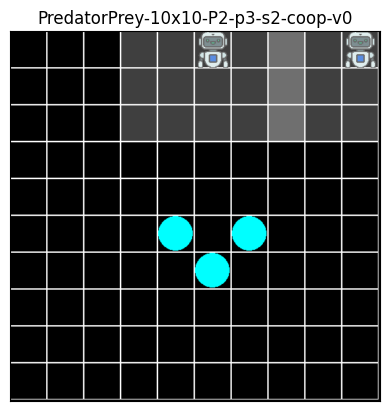

In [2]:
# CHANGE THIS
env_id = "PredatorPrey-10x10-P2-p3-s2-coop-v0"
assert f"{env_id}.csv" in os.listdir(results_dir)
env_result_file = osp.join(results_dir, f"{env_id}.csv")

# display environment
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.set_xticklabels([])
ax.set_yticklabels([])

env = posggym.make(env_id, render_mode="rgb_array")
env.reset()
env_img = env.render()

imshow_obj = ax.imshow(env_img, interpolation='bilinear', origin='upper')
imshow_obj.set_data(env_img)

ax.set_title(env_id)
plt.show()

## Data Loading

In [3]:
def display_df_info(df: pd.DataFrame):
    for k in ["agent_id", "policy_seed", "policy_type"]:
        values = df[k].unique().tolist()
        values.sort()
        print(f"{k}: {values}")

    policy_ids = df["policy_id"].unique().tolist()
    policy_ids.sort()
    print("\nPolicy IDs")
    print("----------")
    for pi_id in policy_ids:
        print(pi_id)
        
    team_ids = df["co_team_id"].unique().tolist()
    team_ids.sort()
    print("\nCo-player Team IDs")
    print("------------------")
    for t_id in team_ids:
        print(t_id)
        
    team_seeds = df["co_team_seed"].unique().tolist()
    team_seeds.sort()
    print("\nCo-player Team Seeds")
    print("--------------------")
    print(team_seeds)
    
    team_types = df["co_team_type"].unique().tolist()
    team_types.sort()
    print("\nCo-player Team Types")
    print("--------------------")
    print(team_types)

    print("\nColumns")
    print("-------")
    for c in df.columns:
        print(c)
        

def add_95CI(df: pd.DataFrame) -> pd.DataFrame:
    """Add 95% CI columns to dataframe."""

    def conf_int(row, prefix):
        std = row[f"{prefix}_std"]
        n = row["num_episodes"]
        return 1.96 * (std / np.sqrt(n))

    prefix = ""
    for col in df.columns:
        if not col.endswith("_std"):
            continue
        prefix = col.replace("_std", "")
        df[f"{prefix}_CI"] = df.apply(lambda row: conf_int(row, prefix), axis=1)
    return df


def add_outcome_proportions(df: pd.DataFrame) -> pd.DataFrame:
    """Add proportion columns to dataframe."""

    def prop(row, col_name):
        n = row["num_episodes"]
        total = row[col_name]
        return total / n

    columns = ["num_LOSS", "num_DRAW", "num_WIN", "num_NA"]
    new_column_names = ["prop_LOSS", "prop_DRAW", "prop_WIN", "prop_NA"]
    for col_name, new_name in zip(columns, new_column_names):
        if col_name in df.columns:
            df[new_name] = df.apply(lambda row: prop(row, col_name), axis=1)
    return df


def clean_df_policy_ids(df: pd.DataFrame) -> pd.DataFrame:
    """Remove environment name from policy ID, if it's present."""

    def clean(row):
        if "/" in row["policy_id"]:
            return row["policy_id"].split("/")[1]
        return row["policy_id"]

    df["policy_id"] = df.apply(clean, axis=1)
    return df


def add_df_coplayer_policy_ids(df: pd.DataFrame) -> pd.DataFrame:
    """Add co-player policy IDs to dataframe.

    Adds a new column for each agent in the environment:

      coplayer_policy_id_0, coplayer_policy_id_1, ..., coplayer_policy_id_N

    Each column contains the policy_id of the agent with corresponding ID for
    the given experiment. 
    
    This includes the row agent so if the row["agent_id"] = i
    then row["coplayer_policy_id_i"] = row["policy_id"]

    """
    agent_ids = df["agent_id"].unique().tolist()
    agent_ids.sort()

    dfs = [df[df["agent_id"] == i] for i in agent_ids]
    for i, df_i in zip(agent_ids, dfs):
        for j, df_j in zip(agent_ids, dfs):
            df_i[f"coplayer_policy_id_{j}"] = df_i["exp_id"].map(
                df_j.set_index("exp_id")["policy_id"].to_dict()
            )
    return pd.concat(dfs).reset_index(drop=True)


def add_policy_seed(df: pd.DataFrame) -> pd.DataFrame:
    """Add policy seeds to dataframe."""

    def policy_seed(row, id_key):
        _, pi_name, _ = parse_policy_id(row[id_key])
        if "_seed" in pi_name:
            seed_token = [t for t in pi_name.split("_") if t.startswith("seed")][0]
            return int(seed_token.replace("seed", ""))
        return 0

    df["policy_seed"] = df.apply(lambda row: policy_seed(row, "policy_id"), axis=1)
    
    agent_ids = df["agent_id"].unique().tolist()
    agent_ids.sort()
    for j in agent_ids:
        df[f"coplayer_policy_seed_{j}"] = df.apply(
            lambda row: policy_seed(row, f"coplayer_policy_id_{j}"), axis=1
        )    
    
    return df


def add_policy_type(df: pd.DataFrame) -> pd.DataFrame:
    """Add policy types to dataframe."""

    def policy_type(row, id_key):
        _, pi_name, _ = parse_policy_id(row[id_key])
        type_tokens = [t for t in pi_name.split("_") if not t.startswith("seed")]
        return "_".join(type_tokens)

    df["policy_type"] = df.apply(lambda row: policy_type(row, "policy_id"), axis=1)
    agent_ids = df["agent_id"].unique().tolist()
    agent_ids.sort()
    for j in agent_ids:
        df[f"coplayer_policy_type_{j}"] = df.apply(
            lambda row: policy_type(row, f"coplayer_policy_id_{j}"), axis=1
        ) 
    
    return df


def add_co_team_id(df: pd.DataFrame) -> pd.DataFrame:
    """Add coplayer team ID column to dataframe."""
    agent_ids = df["agent_id"].unique().tolist()
    agent_ids.sort()

    def get_team_id(row):
        i = row["agent_id"]
        pi_ids = [
            row[f"coplayer_policy_id_{j}"] 
            for j in agent_ids if j != i
        ]
        return tuple(pi_ids)
    
    def get_team_seed(row):
        i = row["agent_id"]
        pi_seeds = [
            row[f"coplayer_policy_seed_{j}"] 
            for j in agent_ids if j != i
        ]
        return tuple(pi_seeds)
    
    def get_team_type(row):
        i = row["agent_id"]
        pi_types = [
            row[f"coplayer_policy_type_{j}"] 
            for j in agent_ids if j != i
        ]
        return tuple(pi_types)

    df["co_team_id"] = df.apply(get_team_id, axis=1)
    df["co_team_seed"] = df.apply(get_team_seed, axis=1)
    df["co_team_type"] = df.apply(get_team_type, axis=1)
    return df


def import_results(result_file: str,) -> pd.DataFrame:
    """Import experiment results."""
    # disable annoying warning
    pd.options.mode.chained_assignment = None
    df = pd.read_csv(result_file)

    df = add_95CI(df)
    df = add_outcome_proportions(df)
    df = clean_df_policy_ids(df)
    df = add_df_coplayer_policy_ids(df)
    df = add_policy_seed(df)
    df = add_policy_type(df)
    df = add_co_team_id(df)
    
    # enable annoyin warning
    pd.options.mode.chained_assignment = "warn"
    return df

In [4]:
df = import_results(env_result_file)
display_df_info(df)

agent_id: [0, 1]
policy_seed: [0, 1, 2, 3, 4]
policy_type: ['random', 'sp']

Policy IDs
----------
random-v0
sp_seed0-v0
sp_seed1-v0
sp_seed2-v0
sp_seed3-v0
sp_seed4-v0

Co-player Team IDs
------------------
('random-v0',)
('sp_seed0-v0',)
('sp_seed1-v0',)
('sp_seed2-v0',)
('sp_seed3-v0',)
('sp_seed4-v0',)

Co-player Team Seeds
--------------------
[(0,), (1,), (2,), (3,), (4,)]

Co-player Team Types
--------------------
[('random',), ('sp',)]

Columns
-------
exp_id
agent_id
env_id
policy_id
exp_seed
num_episodes
time_limit
episode_return_mean
episode_return_std
episode_return_max
episode_return_min
episode_steps_mean
episode_steps_std
episode_time_mean
episode_time_std
num_episode_done
num_LOSS
num_DRAW
num_WIN
num_NA
episode_return_CI
episode_steps_CI
episode_time_CI
prop_LOSS
prop_DRAW
prop_WIN
prop_NA
coplayer_policy_id_0
coplayer_policy_id_1
policy_seed
coplayer_policy_seed_0
coplayer_policy_seed_1
policy_type
coplayer_policy_type_0
coplayer_policy_type_1
co_team_id
co_team_seed


## Pairwise Performance

Here we look at the performance for each possible pairing of policies.

For each performance metric we have a grid of (grid)-plots:
    
- Outer-grid: train seed X train seed
- Inner-grid: policy_id X policy_id

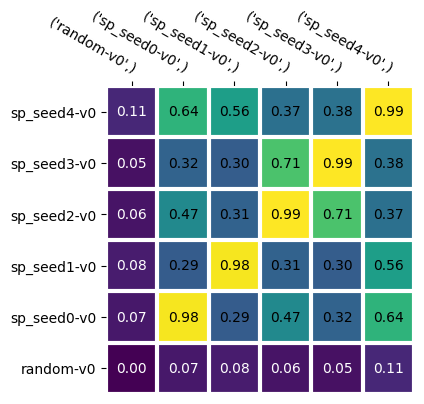

In [5]:
fig_width = len(df["co_team_id"].unique()) // 1.5
fig_height = len(df["policy_id"].unique()) // 1.5

plot_utils.plot_pairwise_comparison(
    df, 
    y_key="episode_return_mean", 
    policy_key="policy_id",
    coplayer_policy_key="co_team_id",
    vrange=None, 
    figsize=(fig_width, fig_height), 
    valfmt="{x:.2f}",
    average_duplicates=True,
    duplicate_warning=False
)

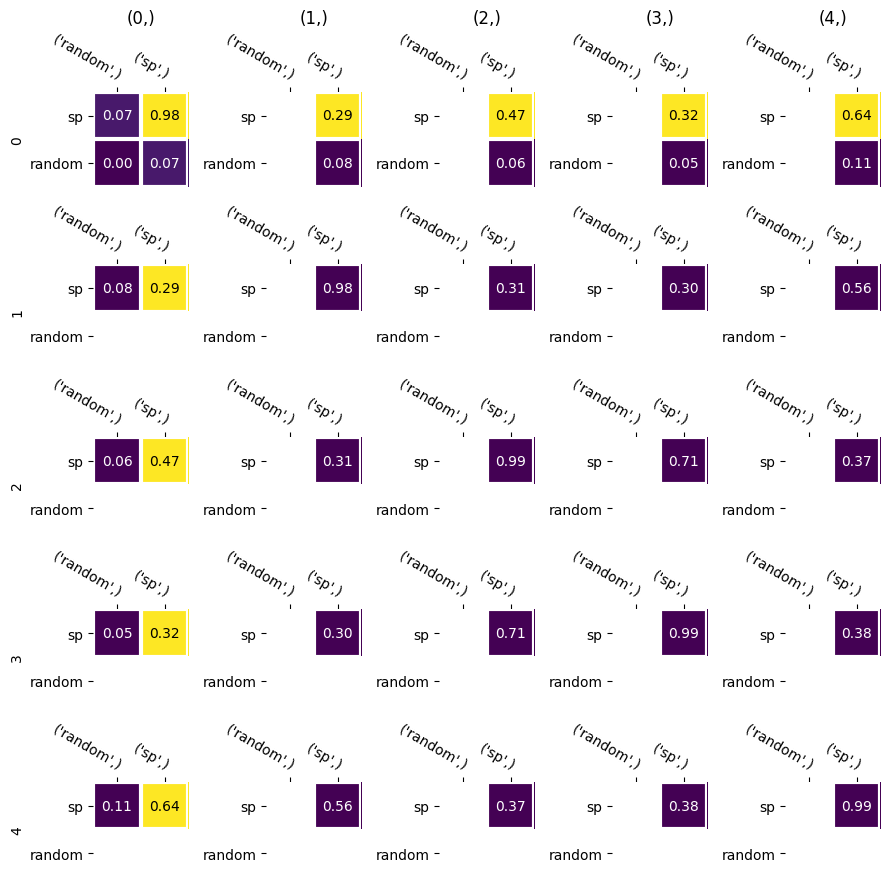

In [6]:
# this may fail for some environments.
# if it does just move to the next plot (i.e. average pop performance)

fig_width = max(9, len(df["co_team_seed"].unique()) * len(df["co_team_type"].unique()) // 1.5)
fig_height = max(9, len(df["policy_seed"].unique()) * len(df["policy_type"].unique()) // 1.5)

fig, axs = plot_utils.plot_pairwise_population_comparison(
    df, 
    y_key="episode_return_mean", 
    pop_key="policy_seed",
    policy_key="policy_type",
    coplayer_pop_key="co_team_seed",
    coplayer_policy_key="co_team_type",
    vrange=None, 
    figsize=(fig_width, fig_height),
    valfmt="{x:.2f}",
    average_duplicates=True,
    duplicate_warning=False
)

### Average performance

Here we look at average performance of the policies.

Each plot shows the *mean performance* for the *row* policy against the *column* policy.

The **left-hand plot** shows *same-play* performance. So performance of policies against policies from the same training population. With the values shown being the mean over all populations.

The **middle plot** shows *cross-play* performance. So performance of policies against policies from different training populations. With the values shown being the mean over all populations.

The **right-hand plot** shows the generalization gap which is just the difference between the *Same-Play* and *Cross-Play* performance.

/home/jonathon/code/posggym-agents/analysis/plot_utils.py:430: RuntimeWarning: Mean of empty slice
  xp_pw_returns[row_policy_idx][col_policy_idx] = np.nanmean(xp_values)


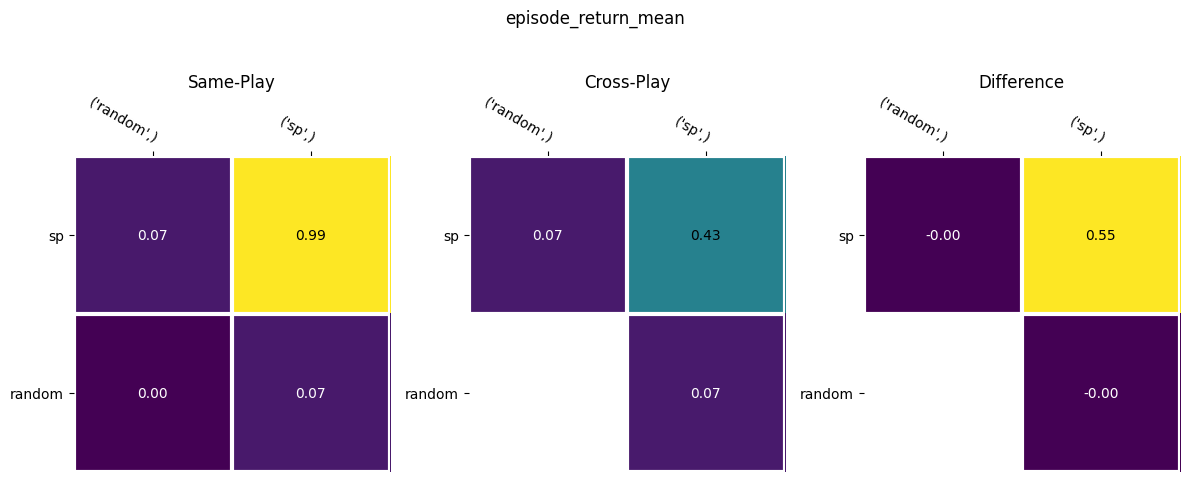

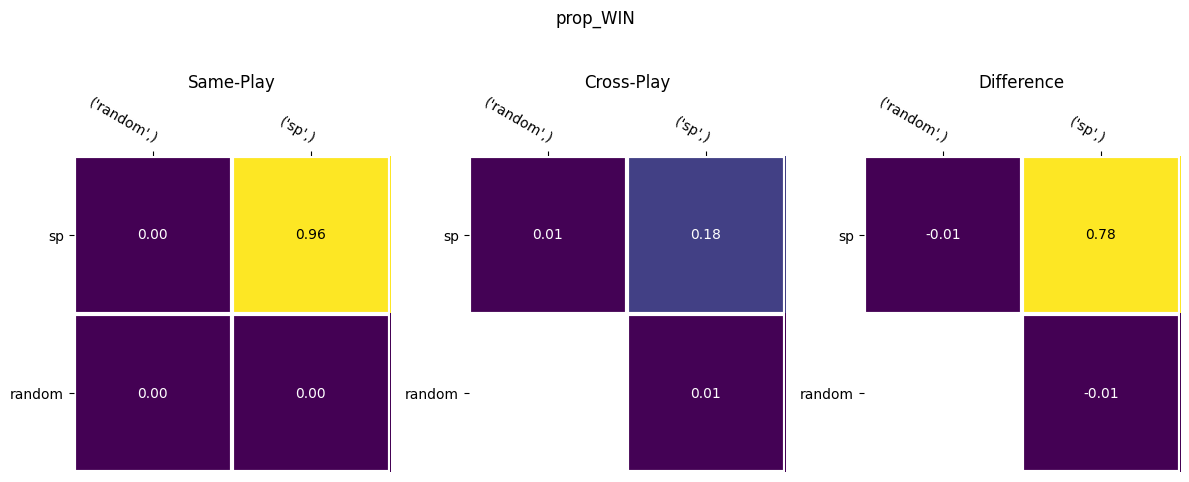

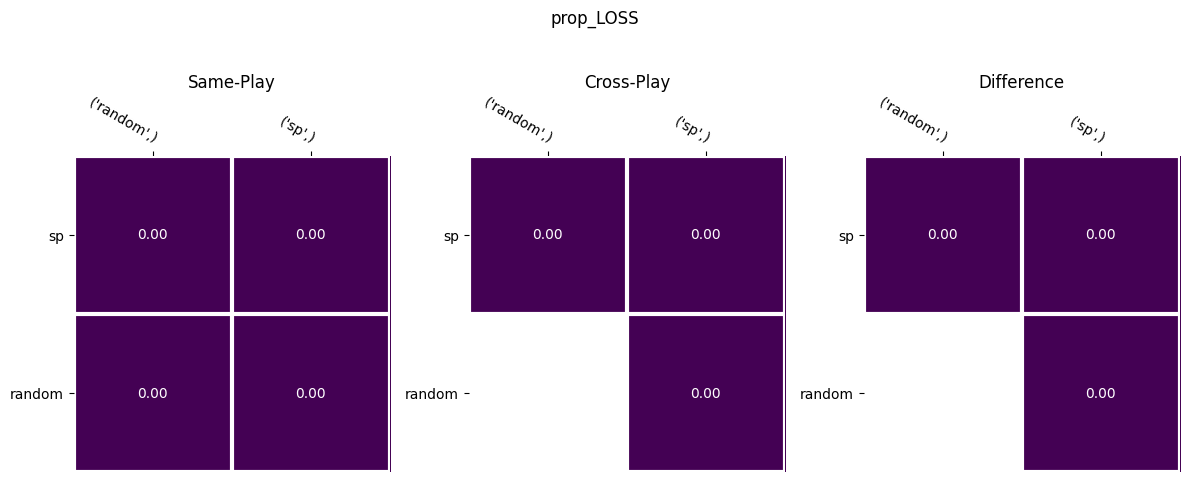

In [7]:
fig_width = max(12, (len(df["co_team_type"].unique()) // 1.25) * 3)
fig_height = max(6, len(df["policy_type"].unique()) // 1.25)

for y_key in ["episode_return_mean", "prop_WIN", "prop_LOSS"]:
    plot_utils.plot_mean_pairwise_comparison(
        df, 
        y_key=y_key, 
        policy_key="policy_type",
        pop_key="policy_seed",
        coplayer_pop_key="co_team_seed",
        coplayer_policy_key="co_team_type",
        vrange=None, 
        figsize=(fig_width, fig_height), 
        valfmt="{x:.2f}"
    )
    
plt.show()